In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors

import h5py
from ipyfilechooser import FileChooser

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from scipy.stats.stats import pearsonr

# Load the full scan

In [2]:
fc = FileChooser('/sf/alvra/data/p18938/raw/scan_info/')  #this is for RC
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p18938/raw/scan_info', filename='', show_hidden='False')

In [29]:
quantile_band = 0.2

# channel_list = [channel_LaserDiode]
channel_list = [channel_PIPS_fluo, channel_Izero117]


################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(fc.selected)
Position_mm = scan.readbacks

Signal = []
Izero117 = []
Izero122 = []

for i, step in enumerate(scan):
    #if i < 29:
        check_files_and_data(step)
        clear_output(wait=True)
        filename = scan.files[i][0].split('/')[-1].split('.')[0]
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

        results, _ = load_data_compact(channel_list, step)

        Izero117_shot = results[channel_Izero117]      
    #     Izero122_shot = results[channel_Izero122]
        signal_shot =  results[channel_PIPS_fluo]

        signal_norm_shot = signal_shot / Izero117_shot              #Normalization with PBPS117
    #     signal_norm_shot = signal_shot / Izero122_shot              #Normalization with PBPS122

        df_signal = pd.DataFrame(signal_norm_shot)
        Signal.append(np.nanquantile(df_signal, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

    #     df_Izero117 = pd.DataFrame(Izero117_shot)
    #     Izero117.append(np.nanquantile(df_Izero117, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

    #     df_Izero122 = pd.DataFrame(Izero122_shot)
    #     Izero122.append(np.nanquantile(df_Izero122, [0.5, 0.5 - quantile_band/2, 0.5 + quantile_band/2]))

Position_mm = Position_mm[:np.shape(Signal)[0]]
Signal = np.asarray(Signal)
# Izero117 = np.asarray(Izero117)
# Izero122 = np.asarray(Izero122)

print ("Job done!")
print ('Quantiles for error bars: {},{}'.format(0.5 - quantile_band/2, 0.5 + quantile_band/2))

Step 21 of 21: Processing run_008430

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   801 / 801 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  200 / 801 -> 75% loss ▇▇
SAROP11-PBPS117:INTENSITY 200 / 801 -> 75% loss ▇▇

over the whole data set: 200 / 801 -> 75% loss
complete channels: 1 / 3 -> 67% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Job done!
Quantiles for error bars: 0.4,0.6


<IPython.core.display.Javascript object>


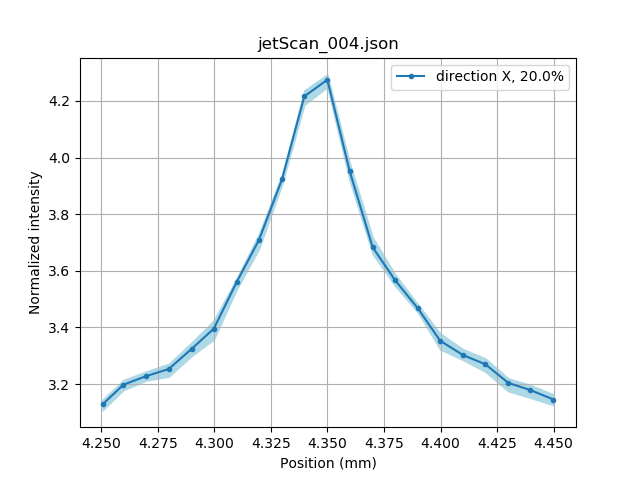

In [30]:
Int = Signal[:,0]
err_low = Signal[:,1]
err_high = Signal[:,2]

plt.figure()
plt.plot(Position_mm, Int, label='direction X, {}%'.format(quantile_band*100),marker='.')
plt.fill_between(Position_mm, err_low, err_high, color='lightblue')

plt.title(fc.selected_filename)
plt.ylabel('Normalized intensity')
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.grid()

plt.show()